In [1]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [2]:

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("../Desktop/BootCampStuff/Repos/A-Reed23/Project_4/140Mtweets.zip", 
                   compression = 'zip',
                      encoding="latin", 
                      header=None, 
                      names=["target","id","date","query","username","text"]
                     )
data.head()

,target,id,date,query,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
val_counts=data.target.value_counts()
val_counts

0    800000
4    800000
Name: target, dtype: int64

In [5]:
data.drop(["id","date","query","username"],axis=1, inplace=True)

In [6]:
data.target = data.target.replace({4: 1})

In [7]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [8]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [9]:
data = pd.concat([data_pos, data_neg])

In [10]:
data['text']=data['text'].str.lower()

In [11]:
data['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [12]:
stopwords_list = stopwords.words('english')

In [13]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [14]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [15]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [16]:
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].head()

800000                   love health4uandpets u guys r best
800001    im meeting one besties tonight cant wait  girl...
800002    darealsunisakim thanks twitter add sunisa got ...
800003    sick really cheap hurts much eat real food plu...
800004                       lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [17]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [18]:
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].head()

800000                   love health4uandpets u guys r best
800001    im meting one besties tonight cant wait girl talk
800002    darealsunisakim thanks twiter ad sunisa got me...
800003    sick realy cheap hurts much eat real fod plus ...
800004                         lovesbroklyn2 efect everyone
Name: text, dtype: object

In [19]:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

In [20]:
data['text']= data['text'].apply(lambda x: cleaning_email(x))
data['text'].tail()

19995    much time wekend work trip malmï¿½ frisat toda...
19996                                     one day holidays
19997                       feling right hate damn humprey
19998    gezi hv read whole bok personality types embar...
19999       threw sign donie bent get thinge made sad face
Name: text, dtype: object

In [21]:
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

In [22]:
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

19995    much time wekend work trip malmï¿½ frisat toda...
19996                                     one day holidays
19997                       feling right hate damn humprey
19998    gezi hv read whole bok personality types embar...
19999       threw sign donie bent get thinge made sad face
Name: text, dtype: object

In [23]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

In [24]:
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

19995    much time wekend work trip malmï¿½ frisat toda...
19996                                     one day holidays
19997                       feling right hate damn humprey
19998    gezi hv read whole bok personality types embar...
19999       threw sign donie bent get thinge made sad face
Name: text, dtype: object

In [25]:
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)

In [26]:
data['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meting, one, besties, tonight, cant, wait...
800002    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800003    [sick, realy, cheap, hurts, much, eat, real, f...
800004                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

In [27]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

data['text']= data['text'].apply(lambda x: stemming_on_text(x))

In [28]:
data['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meting, one, besties, tonight, cant, wait...
800002    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800003    [sick, realy, cheap, hurts, much, eat, real, f...
800004                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

In [29]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [30]:
import nltk

# Download the WordNet resource
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sch\AppData\Roaming\nltk_data...


True

In [31]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))

In [32]:
data['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meting, one, besties, tonight, cant, wait...
800002    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800003    [sick, realy, cheap, hurts, much, eat, real, f...
800004                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

In [33]:
X=data.text
y=data.target

In [34]:
max_len = 500
tok = Tokenizer(num_words=2000)    # the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [35]:
sequences_matrix.shape

(40000, 500)

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

In [37]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

In [38]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])  

In [39]:
history=model.fit(X_train,Y_train,batch_size=80,epochs=6, validation_split=0.1)

Epoch 1/6


315/315 [==============================] - 204s 635ms/step - loss: 0.6151 - accuracy: 0.6437 - val_loss: 0.5369 - val_accuracy: 0.7296
Epoch 2/6
315/315 [==============================] - 200s 636ms/step - loss: 0.5151 - accuracy: 0.7505 - val_loss: 0.5317 - val_accuracy: 0.7357
Epoch 3/6
315/315 [==============================] - 180s 572ms/step - loss: 0.4969 - accuracy: 0.7619 - val_loss: 0.5201 - val_accuracy: 0.7368
Epoch 4/6
315/315 [==============================] - 175s 554ms/step - loss: 0.4851 - accuracy: 0.7703 - val_loss: 0.5217 - val_accuracy: 0.7361
Epoch 5/6
315/315 [==============================] - 165s 524ms/step - loss: 0.4791 - accuracy: 0.7728 - val_loss: 0.5248 - val_accuracy: 0.7450
Epoch 6/6
315/315 [==============================] - 176s 559ms/step - loss: 0.4807 - accuracy: 0.7713 - val_loss: 0.5373 - val_accuracy: 0.7400


In [40]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

375/375 [==============================] - 28s 71ms/step - loss: 0.5255 - accuracy: 0.7474


In [41]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5) 

375/375 [==============================] - 29s 74ms/step




confusion matrix


[[4579 1430]
 [1601 4390]]




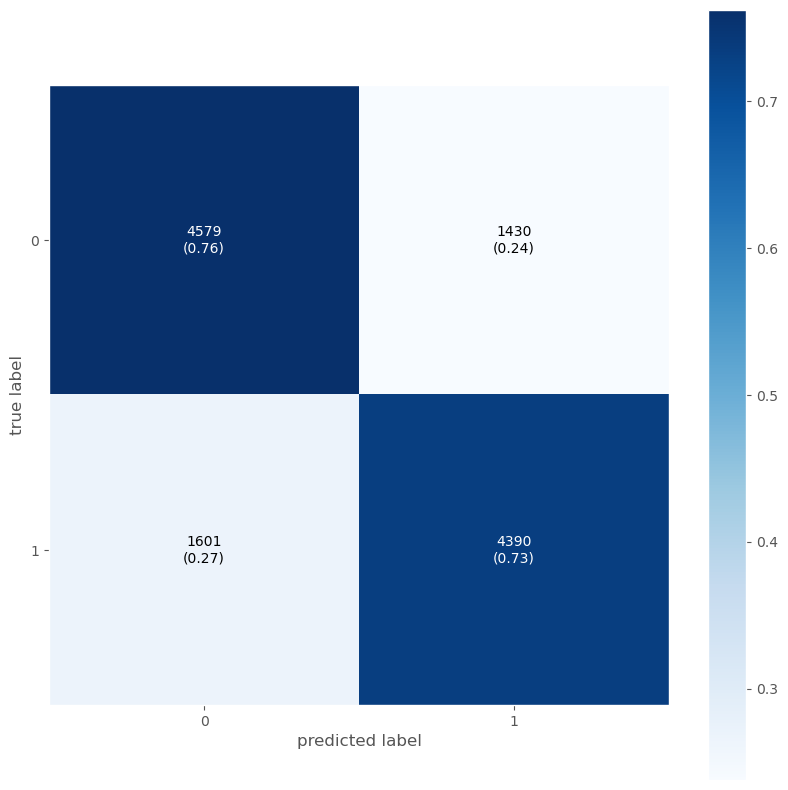

In [42]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [43]:
import pickle
file = 'TensorTrained.sav'
pickle.dump(model, open(file, 'wb'))

In [44]:
# https://stackoverflow.com/questions/45735070/keras-text-preprocessing-saving-tokenizer-object-to-file-for-scoring
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)
